In [9]:
import os
from math import sqrt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
root_dir = os.path.join('.', 'data')

if not os.path.exists(root_dir):
    os.mkdir(root_dir)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST(root_dir, train=True, transform=transform, download=True)

In [11]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=128)

In [12]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, input):
        B, C, H, W = input.size()
        return input.view(B, -1)

    def __repr__(self):
        return self.__class__.__name__ + ' ()'

In [13]:
class SELU(nn.Module):
    def __init__(self, 
                 alpha = 1.6732632423543772848170429916717, 
                 scale = 1.0507009873554804934193349852946, 
                 inplace=False):
        super(SELU, self).__init__()
        self.alpha = alpha
        self.scale = scale
        self.inplace = inplace

    def forward(self, input):
        return self.scale * F.elu(input, self.alpha, self.inplace)

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' (' \
            + 'alpha=' + str(self.alpha) \
            + ' scale=' + str(self.scale) \
            + inplace_str + ')'

In [14]:
class AlphaDropout(nn.Module):
    def __init__(self,
                 p=0.05,
                 alpha_prime = -1.75809934084738):
        super(AlphaDropout, self).__init__()
        self.dropout_prob = p
        self.keep_prob = 1 - p
        self.alpha_prime = alpha_prime
        
        # a = (q + alpha_prime^2 * q * (1 - q))^(-1/2)
        self.a = 1 / np.sqrt(self.keep_prob + pow(self.alpha_prime, 2) * self.keep_prob * p)
        # b = -a * ((1-q) * alpha_prime)
        self.b = -self.a * (p * self.alpha_prime)
        
    def forward(self, x):
        if self.keep_prob == 1 or not self.training:
            return x
        
        random_tensor = self.keep_prob + torch.rand(x.size())
        binary_tensor = Variable(torch.floor(random_tensor)).cuda()
        
        # a(xd + alpha_prime(1 - d)) + b
        ret = x.mul(binary_tensor) + self.alpha_prime * (1 - binary_tensor)
        ret.mul_(self.a).add_(self.b)
        return ret
    
    def __repr__(self):
        return self.__class__.__name__ + ' ()'

In [15]:
def init_model_weights(model):
    init.normal(model.conv1.weight, mean=0, std=sqrt(2.0/25.0))
    init.normal(model.conv2.weight, mean=0, std=sqrt(2.0/(25.0*32.0)))
    init.normal(model.linear1.weight, mean=0, std=sqrt(2.0/(7.0*7.0*64.0)))
    init.normal(model.linear1.weight, mean=0, std=sqrt(2.0/(1024.0)))
    
    init.constant(model.conv1.bias, 0)
    init.constant(model.conv2.bias, 0)
    init.constant(model.linear1.bias, 0)
    init.constant(model.linear2.bias, 0)

def get_selu_model():
    model = nn.Sequential(OrderedDict([
        ('conv1', nn.Conv2d(1, 32, 5, stride=1, padding=2)),
        ('selu1', SELU(inplace=True)),
        ('maxpool1', nn.MaxPool2d((2,2), stride=2)),
        ('conv2', nn.Conv2d(32, 64, 5, stride=1, padding=2)),
        ('selu2', SELU(inplace=True)),
        ('maxpool2', nn.MaxPool2d((2,2), stride=2)),
        ('flatten', Flatten()),
        ('linear1', nn.Linear(7*7*64, 1024)),
        ('selu3', SELU(inplace=True)),
        ('d1', AlphaDropout(0.05)),
        ('linear2', nn.Linear(1024, 10)),
    ]))
    
    return model

def get_relu_model():
    model = nn.Sequential(OrderedDict([
        ('conv1', nn.Conv2d(1, 32, 5, stride=1, padding=2)),
        ('relu1', nn.ReLU(inplace=True)),
        ('maxpool1', nn.MaxPool2d((2,2), stride=2)),
        ('conv2', nn.Conv2d(32, 64, 5, stride=1, padding=2)),
        ('relu2', nn.ReLU(inplace=True)),
        ('maxpool2', nn.MaxPool2d((2,2), stride=2)),
        ('flatten', Flatten()),
        ('linear1', nn.Linear(7*7*64, 1024)),
        ('relu3', nn.ReLU(inplace=True)),
        ('d1', nn.Dropout(0.05)),
        ('linear2', nn.Linear(1024, 10)),
    ]))
    
    return model

In [16]:
model_selu = get_selu_model()
init_model_weights(model_selu)

model_relu = get_relu_model()
init_model_weights(model_relu)

model_selu.cuda()
model_relu.cuda()

print(model_selu)
print(model_relu)

Sequential (
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (selu1): SELU (alpha=1.6732632423543772 scale=1.0507009873554805, inplace)
  (maxpool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (selu2): SELU (alpha=1.6732632423543772 scale=1.0507009873554805, inplace)
  (maxpool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (flatten): Flatten ()
  (linear1): Linear (3136 -> 1024)
  (selu3): SELU (alpha=1.6732632423543772 scale=1.0507009873554805, inplace)
  (d1): AlphaDropout ()
  (linear2): Linear (1024 -> 10)
)
Sequential (
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU (inplace)
  (maxpool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU (inplace)
  (maxpool2): MaxPool2d (size=(2, 2), stride=(2, 2), dila

In [17]:
optimizer_selu = optim.SGD(model_selu.parameters(), lr=0.025)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=0.025)
criterion = nn.CrossEntropyLoss()

In [18]:
def train(images, labels, model, optimizer, criterion):
    optimizer.zero_grad()
    
    images_var = Variable(images).cuda()
    labels_var = Variable(labels, requires_grad=False).cuda()
    
    scores = model(images_var)
    
    loss = criterion(scores, labels_var)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

In [19]:
num_epochs = 10

selu_losses = []
relu_losses = []

for epoch in range(num_epochs):
    epoch_selu_losses = []
    epoch_relu_losses = []
    
    for data in data_loader:
        images, labels = data
        loss_selu = train(images, labels, model_selu, optimizer_selu, criterion)
        loss_relu = train(images, labels, model_relu, optimizer_relu, criterion)
        
        epoch_selu_losses.append(loss_selu)
        epoch_relu_losses.append(loss_relu)
        
    average_selu_loss = sum(epoch_selu_losses) / float(len(epoch_selu_losses))
    average_relu_loss = sum(epoch_relu_losses) / float(len(epoch_relu_losses))
    
    print('Current Epoch {}: SELU Loss = {} :: RELU Loss = {}'.
          format(epoch+1, average_selu_loss, average_relu_loss))
    
    selu_losses.append(average_selu_loss)
    relu_losses.append(average_relu_loss)

Current Epoch 1: SELU Loss = 0.3987813304378979 :: RELU Loss = 0.3394212085507445
Current Epoch 2: SELU Loss = 0.059161250938230485 :: RELU Loss = 0.07074233306162774
Current Epoch 3: SELU Loss = 0.040227992158295756 :: RELU Loss = 0.050990401876411205
Current Epoch 4: SELU Loss = 0.02980473389261281 :: RELU Loss = 0.040631639705633306
Current Epoch 5: SELU Loss = 0.023271257589970316 :: RELU Loss = 0.034249522411492844
Current Epoch 6: SELU Loss = 0.018317874675906544 :: RELU Loss = 0.028669884523698515
Current Epoch 7: SELU Loss = 0.01430354887909536 :: RELU Loss = 0.024426685487315344
Current Epoch 8: SELU Loss = 0.01174130262946015 :: RELU Loss = 0.020809142328083896
Current Epoch 9: SELU Loss = 0.009968539876644927 :: RELU Loss = 0.01889758503068485
Current Epoch 10: SELU Loss = 0.007908670148297922 :: RELU Loss = 0.016145774594216206


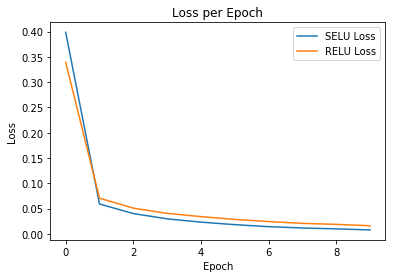

In [20]:
plt.plot(range(len(selu_losses)), selu_losses)
plt.plot(range(len(relu_losses)), relu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend(['SELU Loss', 'RELU Loss'])
plt.show()